In [1]:
DATASET_data="rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.root"
DATASET_MC_0012_v1="nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v1.root"
DATASET_MC_0012_v2="nts.mu2e.CRV_wideband_cosmics-mc.config_0012_v2.root"
DATASET_MC_v2="nts.mu2e.WidebandCRV_v2.MDC2020ag.root"
DATASET_MC_v4="nts.mu2e.WidebandCRV_v4.MDC2020ag.root"
DATASET_MC_v5="nts.mu2e.WidebandCRV_v5.MDC2020ag.root"
DATASET_MC_v6="nts.mu2e.WidebandCRV_v6.MDC2020ag.root"
DATASET_MC_v7="nts.mu2e.WidebandCRV_v7.MDC2020ag.root"
DATASET_MC_v8="nts.mu2e.WidebandCRV_v8.MDC2020ag.root"
DATASET_MC_v9="nts.mu2e.WidebandCRV_v9.MDC2020ag.root"
DATASET_MC_v10="nts.mu2e.WidebandCRV_v10.MDC2020ag.root"
DATASET_MC_v11="nts.mu2e.WidebandCRV_v11.MDC2020ag.root"
DATASET_MC_v13="nts.mu2e.WidebandCRV_v13.MDC2020ag.root"
DATASET_MC_v15="nts.mu2e.WidebandCRV_v15.MDC2020ag.root"

In [2]:
import time
import os
import numpy as np
import gc
from mu2etools import *
from mu2etools import wideband
import hist
from hist import Hist

hep.style.use('ATLAS')

In [3]:
def SelectionCuts(DATASET, isMC=False, isNew=True, cleanup=True):
    if isMC:
        processor = wideband.DataProcessor(treename='CrvWidebandTest/run', runlist=[1738], userunlist=False, remove=False)
        filelist = processor.getFilelist(DATASET, root_schema=True)
        filelist = ["{}{}".format(i, ":CrvWidebandTest/run") for i in filelist]
        PEs = 'PEs'
    else:
        runs = [1720, 1721, 1722, 1723, 1724, 1727, 1728, 1729, 1730, 1731, 1732, 1738, 2004, 2005, 2006, 2007, 2008, 2009, 2015, 2024, 2025, 2026, 2027, 2028]
        processor = wideband.DataProcessor(treename='run', runlist=runs, userunlist=True, remove=False)
        filelist = processor.getFilelist(DATASET, root_schema=True)
        filelist = ["{}{}".format(i, ":run") for i in filelist]
        PEs = 'PEsTemperatureCorrected'

    # List of variable to import
    varlist=[PEs, 'trackIntercept', 'trackChi2', 'trackPoints', 'trackPEs', 
             'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
    varlist_keep = ['PEs_testlayers', 'runNumber', 'subrunNumber', 'spillNumber', 'eventNumber']
    
    if isMC:
        varlist.append('coincidencePosX')
        varlist.append('coincidencePDGid')

    ar_skim_list = []

    allevents = 0
    cutevents = 0

    allfiles = 0
    filesloaded = 0

    for idx, filename in enumerate(filelist):
        if idx%100 == 0:
            print("Processing file: %s"%filename)
        try:
            allfiles += 1
            with uproot.open(filename) as file:
                for ar in file.iterate(step_size="10MB", 
                                               filter_name=varlist, 
                                               report=False, library='ak'):
                    allevents += len(ar["eventNumber"])
    
                    if isMC:
                        ar = ar[(abs(ar["coincidencePosX"][:,1]+5604) < 50) & (abs(ar["coincidencePosX"][:,4] + 5604) < 50)]
    
                    ar = ar[(ak.mean(ar[PEs][:,0,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,0,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,1,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,1,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,2,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,2,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,3,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,3,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,4,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,4,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,5,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,5,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,6,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,6,32:64], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,7,0:32], axis=-1)>=0) &
                            (ak.mean(ar[PEs][:,7,32:64], axis=-1)>=0)]                           
    
    
                    ar[PEs] = ak.where(ar[PEs] >= 5, ar[PEs], 0)
    
                    FEB0_0 = (ak.sum(ar[PEs][:,0,8:28], axis=-1)>10)
                    FEB0_1 = (ak.sum(ar[PEs][:,0,36:60], axis=-1)>10)
    
                    FEB1_0 = (ak.sum(ar[PEs][:,1,4:28], axis=-1)>10) #0:32
                    FEB1_1 = (ak.sum(ar[PEs][:,1,36:60], axis=-1)>10)
    
                    FEB2_0 = (ak.sum(ar[PEs][:,2,4:28], axis=-1)>10)
                    FEB2_1 = (ak.sum(ar[PEs][:,2,36:60], axis=-1)>10) #32:64
    
                    FEB3_0 = (ak.sum(ar[PEs][:,3,8:28], axis=-1)>10)
                    FEB3_1 = (ak.sum(ar[PEs][:,3,36:60], axis=-1)>10)
    
                    FEB4_0 = (ak.sum(ar[PEs][:,4,4:28], axis=-1)>10)
                    FEB4_1 = (ak.sum(ar[PEs][:,4,36:60], axis=-1)>10)
    
                    FEB5_0 = (ak.sum(ar[PEs][:,5,4:28], axis=-1)>10)
                    FEB5_1 = (ak.sum(ar[PEs][:,5,36:60], axis=-1)>10)
    
                    FEB6_0 = (ak.sum(ar[PEs][:,6,4:28], axis=-1)>10)
                    FEB6_1 = (ak.sum(ar[PEs][:,6,36:60], axis=-1)>10)
    
                    FEB7_0 = (ak.sum(ar[PEs][:,7,4:28], axis=-1)>10)
                    FEB7_1 = (ak.sum(ar[PEs][:,7,36:60], axis=-1)>10)
    
                    nTrigHits = ak.values_astype(FEB0_0, "int") + ak.values_astype(FEB0_1, "int") + \
                                ak.values_astype(FEB3_0, "int") + ak.values_astype(FEB3_1, "int") + \
                                ak.values_astype(FEB4_0, "int") + ak.values_astype(FEB4_1, "int") + \
                                ak.values_astype(FEB5_0, "int") + ak.values_astype(FEB5_1, "int") + \
                                ak.values_astype(FEB6_0, "int") + ak.values_astype(FEB6_1, "int") + \
                                ak.values_astype(FEB7_0, "int") + ak.values_astype(FEB7_1, "int")
    
                    if isMC and isNew:
                        ar['trackIntercept'] = ar['trackIntercept'][:,0] - 20950.0#39950.0
    
                        ar['trackChi2NDF'] = ak.where(ar['trackPoints'][:,0] > 2, ar['trackChi2'][:,0] / (ar['trackPoints'][:,0] - 2), -999)
                        ar['trackPEs'] = ar['trackPEs'][:,0]
                        ar['trackPoints'] = ar['trackPoints'][:,0]
                    if isMC and not isNew:
                        ar['trackIntercept'] = ar['trackIntercept'] - 20950.0
                        ar['trackChi2NDF'] = ak.where(ar['trackPoints'] > 2, ar['trackChi2'] / (ar['trackPoints'] - 2), -999)
                    if not isMC:
                        ar['trackChi2NDF'] = ak.where(ar['trackPoints'] > 2, ar['trackChi2'] / (ar['trackPoints'] - 2), -999)
                    
                    ar["PEs_testlayers"] = ar[PEs][:,np.arange(1,3)]
    
                    #ar_cleanup = ar[(nTrigHits >=11) & (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) & (ar["trackPEs"] < 2600) & (ar["trackChi2NDF"] < 25) & (ar["trackChi2NDF"] > 0)]
                    ar_cleanup = ar[(nTrigHits >=12) &
                                    (ar["trackIntercept"] < -200) & (ar["trackIntercept"] > -700) &
                                    (ar["trackPEs"] < 3000) & 
                                    (ar["trackPoints"] < 40) &
                                    (ar["trackChi2NDF"] < 30) & (ar["trackChi2NDF"] > 0)]
                    ar_169 = ar[FEB1_0 & FEB2_1]

                    if isMC:
                        ar_169 = ar_169[abs(ar_169['coincidencePDGid'][:,2]) == 13]
    
                    if cleanup:
                        ar_skim_list.append(ar_cleanup[varlist_keep])
                        cutevents += len(ar_cleanup["eventNumber"])
    
                    else:
                        ar_skim_list.append(ar_169[varlist_keep])
                        cutevents += len(ar_169["eventNumber"])
    
                    filesloaded += 1
        except:
            continue


    print("{0} files loaded out of {1}".format(filesloaded, allfiles))
    print("Total events: {0}".format(allevents))
    print("Events after cuts: {0}".format(cutevents))
    
    return ar_skim_list

In [4]:
def GetEfficiencyCleanup(ar_skim_list):
    thresh = np.linspace(10, 130, 25, endpoint=True)
    pass_1_0 = np.zeros_like(thresh)
    pass_1_1 = np.zeros_like(thresh)
    pass_2_0 = np.zeros_like(thresh)
    pass_2_1 = np.zeros_like(thresh)
    pass_3of4 = np.zeros_like(thresh)
    nTrig = np.zeros_like(thresh)

    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]

        for j in range(len(thresh)):
            ## testing module layers ##
            FEB1_0 = (ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1)>thresh[j])
            FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
            FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])
            FEB2_1 = (ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1)>thresh[j])

            nHits_test = ak.values_astype(FEB1_0, "int") + ak.values_astype(FEB1_1, "int") + \
                         ak.values_astype(FEB2_0, "int") + ak.values_astype(FEB2_1, "int")

            pass_1_0[j] += ak.count(ar_clean[FEB1_0]["eventNumber"])
            pass_1_1[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
            pass_2_0[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
            pass_2_1[j] += ak.count(ar_clean[FEB2_1]["eventNumber"])
            pass_3of4[j] += ak.count(ar_clean[(nHits_test >= 3)]["eventNumber"])
            nTrig[j] += ak.count(ar_clean["eventNumber"])
            
    ineff_layer0 = np.zeros_like(thresh)
    ineff_layer1 = np.zeros_like(thresh)
    ineff_layer2 = np.zeros_like(thresh)
    ineff_layer3 = np.zeros_like(thresh)

    ineff_extrapolated = np.zeros_like(thresh)

    for i in range(len(thresh)):
        ineff_0 = 1 - pass_1_0[i]/nTrig[i]
        ineff_1 = 1 - pass_1_1[i]/nTrig[i]
        ineff_2 = 1 - pass_2_0[i]/nTrig[i]
        ineff_3 = 1 - pass_2_1[i]/nTrig[i]

        eff_avg = (pass_1_0[i]/nTrig[i] + pass_1_1[i]/nTrig[i] + \
                   pass_2_0[i]/nTrig[i] + pass_2_1[i]/nTrig[i])/4

        eff_3of4 = 4*eff_avg**3 - 3*eff_avg**4

        ineff_layer0[i] = ineff_0
        ineff_layer1[i] = ineff_1
        ineff_layer2[i] = ineff_2
        ineff_layer3[i] = ineff_3
        ineff_extrapolated[i] = 1 - eff_3of4
        
    ineff_3of4 = np.ones_like(thresh) - np.divide(pass_3of4, nTrig)
    error_3of4 = np.zeros_like(thresh)
    for i in range(len(thresh)):
        error_3of4[i] = np.sqrt(ineff_3of4[i]*(1-ineff_3of4[i])/nTrig[i])
        
    return np.array([ineff_layer0, ineff_layer1, ineff_layer2, ineff_layer3, ineff_extrapolated, ineff_3of4, error_3of4, nTrig])

In [5]:
def GetEfficiencySingle(ar_skim_list):
    thresh = np.linspace(10, 130, 25, endpoint=True)
    pass_1_1 = np.zeros_like(thresh)
    pass_2_0 = np.zeros_like(thresh)
    pass_1of2 = np.zeros_like(thresh)
    nTrig = np.zeros_like(thresh)

    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]

        for j in range(len(thresh)):
            ## testing module layers ##
            FEB1_1 = (ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1)>thresh[j])
            FEB2_0 = (ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1)>thresh[j])

            nHits_test = ak.values_astype(FEB1_1, "int") + ak.values_astype(FEB2_0, "int")

            pass_1_1[j] += ak.count(ar_clean[FEB1_1]["eventNumber"])
            pass_2_0[j] += ak.count(ar_clean[FEB2_0]["eventNumber"])
            pass_1of2[j] += ak.count(ar_clean[(nHits_test >= 1)]["eventNumber"])
            nTrig[j] += ak.count(ar_clean["eventNumber"])
            
    ineff_layer1 = np.zeros_like(thresh)
    ineff_layer2 = np.zeros_like(thresh)

    ineff_extrapolated = np.zeros_like(thresh)

    for i in range(len(thresh)):
        ineff_1 = 1 - pass_1_1[i]/nTrig[i]
        ineff_2 = 1 - pass_2_0[i]/nTrig[i]

        eff_avg = (pass_1_1[i]/nTrig[i] + pass_2_0[i]/nTrig[i])/2

        eff_1of2 = 2*eff_avg - eff_avg**2

        ineff_layer1[i] = ineff_1
        ineff_layer2[i] = ineff_2
        ineff_extrapolated[i] = 1 - eff_1of2
        
    ineff_1of2 = np.ones_like(thresh) - np.divide(pass_1of2, nTrig)
    error_1of2 = np.zeros_like(thresh)
    for i in range(len(thresh)):
        error_1of2[i] = np.sqrt(ineff_1of2[i]*(1-ineff_1of2[i])/nTrig[i])
        
    return np.array([ineff_layer1, ineff_layer2, ineff_extrapolated, ineff_1of2, error_1of2, nTrig])

In [29]:
def GetLightYield(ar_skim_list):
    #h = Hist(hist.axis.Regular(bins=300, start=0, stop=300, name="light yield"))
    h = Hist(hist.axis.Regular(bins=60, start=0, stop=300, name="light yield", flow=False))
    for i in range(len(ar_skim_list)):
        ar_clean = ar_skim_list[i]
        
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,0,0:32], axis=-1))
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,0,32:64], axis=-1))
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,1,0:32], axis=-1))
        h.fill(ak.sum(ar_clean["PEs_testlayers"][:,1,32:64], axis=-1))
        
    return h

In [7]:
ar_skim_list_data = SelectionCuts(DATASET_data, False, False, True)
ineff_data = GetEfficiencyCleanup(ar_skim_list_data)

ineff_layer0_data = ineff_data[0]
ineff_layer1_data = ineff_data[1]
ineff_layer2_data = ineff_data[2]
ineff_layer3_data = ineff_data[3]

ineff_extrapolated_data = ineff_data[4]
ineff_3of4_data = ineff_data[5]
error_3of4_data = ineff_data[6]
nTrig_data = ineff_data[7]

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/fc/22/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001720_000.root:run


/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: divide by zero encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)
/home/thoroho/.conda/envs/Mu2eCRV/lib/python3.10/site-packages/awkward/_backends.py:57: RuntimeWarning: invalid value encountered in divide
  return getattr(ufunc, method)(*args, **kwargs)


492 files loaded out of 75
Total events: 9815702
Events after cuts: 2195938


In [8]:
ineff_data2 = GetEfficiencySingle(ar_skim_list_data)

ineff_layer1_data_single = ineff_data2[0]
ineff_layer1_data_single - ineff_data2[1]

ineff_1of2_extrapolated_data = ineff_data2[2]
ineff_1of2_data = ineff_data2[3]
error_1of2_data = ineff_data2[4]

In [30]:
hData = GetLightYield(ar_skim_list_data)

In [9]:
error_layer0_data = np.linspace(10,130,25,endpoint=True)
error_layer1_data = np.linspace(10,130,25,endpoint=True)
error_layer2_data = np.linspace(10,130,25,endpoint=True)
error_layer3_data = np.linspace(10,130,25,endpoint=True)

for i in range(len(error_layer0_data)):
    error_layer0_data[i] = np.sqrt(ineff_layer0_data[i]*(1-ineff_layer0_data[i])/nTrig_data[i])

for i in range(len(error_layer1_data)):
    error_layer1_data[i] = np.sqrt(ineff_layer1_data[i]*(1-ineff_layer1_data[i])/nTrig_data[i])

for i in range(len(error_layer2_data)):
    error_layer2_data[i] = np.sqrt(ineff_layer2_data[i]*(1-ineff_layer2_data[i])/nTrig_data[i])

for i in range(len(error_layer3_data)):
    error_layer3_data[i] = np.sqrt(ineff_layer3_data[i]*(1-ineff_layer3_data[i])/nTrig_data[i])

In [7]:
ineff_extrapolated_data = [5.80619416e-06, 7.24190883e-06, 9.84454203e-06, 1.39584470e-05,
                           2.07129148e-05, 3.08754852e-05, 4.64224524e-05, 7.21148195e-05,
                           1.15809772e-04, 1.92459630e-04, 3.40664664e-04, 6.54086856e-04,
                           1.42825341e-03, 3.57803058e-03, 9.81134249e-03, 2.68443264e-02,
                           6.73952210e-02, 1.46978799e-01, 2.71909725e-01, 4.27622432e-01,
                           5.85162031e-01, 7.18608331e-01, 8.16673081e-01, 8.82137579e-01, 9.23500312e-01]
ineff_3of4_data = [4.05736940e-06, 4.50818822e-06, 4.50818822e-06, 4.50818822e-06, 4.50818822e-06,
                   4.50818822e-06, 4.50818822e-06, 4.95900704e-06, 4.95900704e-06, 1.08196517e-05,
                   3.65163246e-05, 1.80327529e-04, 8.18236162e-04, 3.13499409e-03, 1.02245709e-02,
                   2.94443297e-02, 7.35096155e-02, 1.56029747e-01, 2.80152341e-01, 4.29847181e-01,
                   5.78556532e-01, 7.03741255e-01, 7.96366490e-01, 8.59270142e-01, 8.99913713e-01]
error_3of4_data = [1.35245372e-06, 1.42561108e-06, 1.42561108e-06, 1.42561108e-06, 1.42561108e-06,
                   1.42561108e-06, 1.42561108e-06, 1.49519317e-06, 1.49519317e-06, 2.20854021e-06,
                   4.05729532e-06, 9.01556346e-06, 1.91982925e-05, 3.75350984e-05, 6.75447968e-05,
                   1.13504239e-04, 1.75223985e-04, 2.43651053e-04, 3.01521612e-04, 3.32394401e-04,
                   3.31545841e-04, 3.06579502e-04, 2.70384712e-04, 2.33485011e-04, 2.01506353e-04]

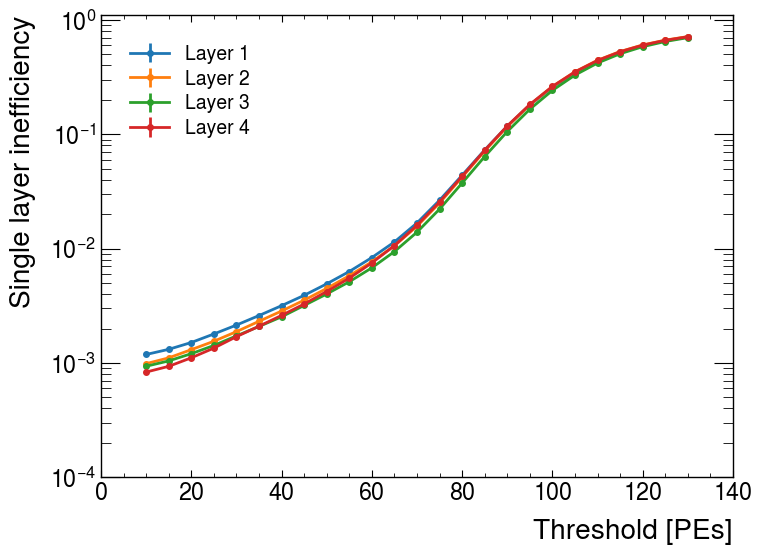

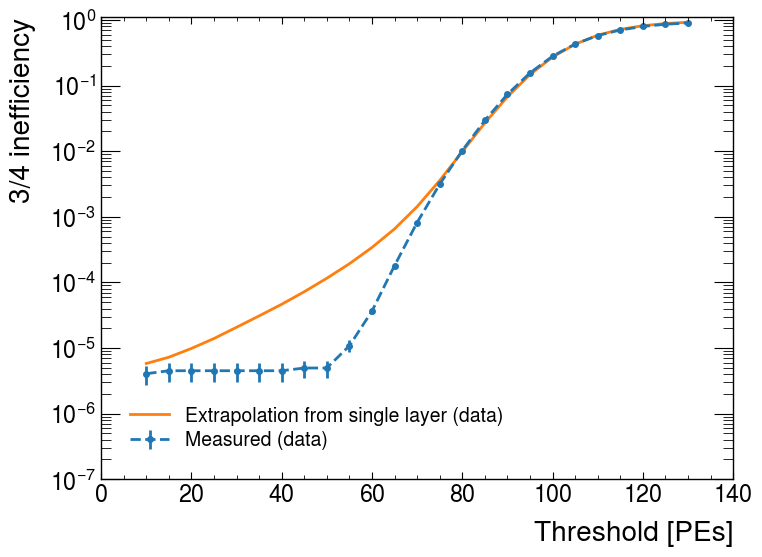

In [10]:
fig, ax = plt.subplots()

#ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer0_data, '.-', label='Layer 0')
#ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_data, '.-', label='Layer 1')
#ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_data, '.-', label='Layer 2')
#ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer3_data, '.-', label='Layer 3')

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer0_data, yerr=error_layer0_data, fmt='.-', label="Layer 1")
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer1_data, yerr=error_layer1_data, fmt='.-', label="Layer 2")
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer2_data, yerr=error_layer2_data, fmt='.-', label="Layer 3")
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_layer3_data, yerr=error_layer3_data, fmt='.-', label="Layer 4")

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

plt.show()


fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, yerr=error_3of4_data, fmt='.--', label='Measured (data)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', label='Extrapolation from single layer (data)')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

plt.show()

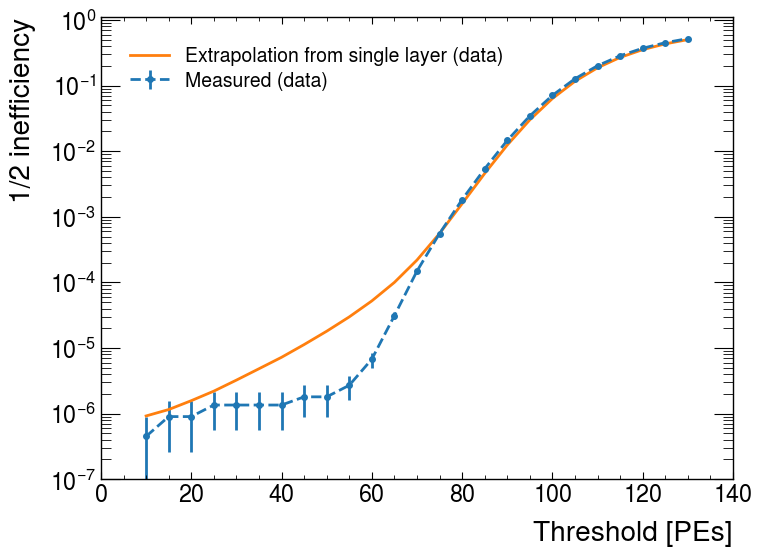

In [11]:
fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_1of2_data, yerr=error_1of2_data, fmt='.--', label='Measured (data)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_1of2_extrapolated_data, '-', label='Extrapolation from single layer (data)')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('1/2 inefficiency')

plt.show()

In [9]:
ar_skim_list_MC_v15 = SelectionCuts(DATASET_MC_v15, isMC=True, isNew=True, cleanup=True)
ineff = GetEfficiencyCleanup(ar_skim_list_MC_v15)

ineff_layer0_MC_v15 = ineff[0]
ineff_layer1_MC_v15 = ineff[1]
ineff_layer2_MC_v15 = ineff[2]
ineff_layer3_MC_v15 = ineff[3]

ineff_extrapolated_MC_v15 = ineff[4]
ineff_3of4_MC_v15 = ineff[5]
error_3of4_MC_v15 = ineff[6]

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v15/MDC2020ag/root/ca/78/nts.mu2e.WidebandCRV_v15.MDC2020ag.103001_00000000.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v15/MDC2020ag/root/3e/9f/nts.mu2e.WidebandCRV_v15.MDC2020ag.103001_00000160.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v15/MDC2020ag/root/52/d3/nts.mu2e.WidebandCRV_v15.MDC2020ag.103001_00000321.root:CrvWidebandTest/run
502 files loaded out of 252
Total events: 14617337
Events after cuts: 240220


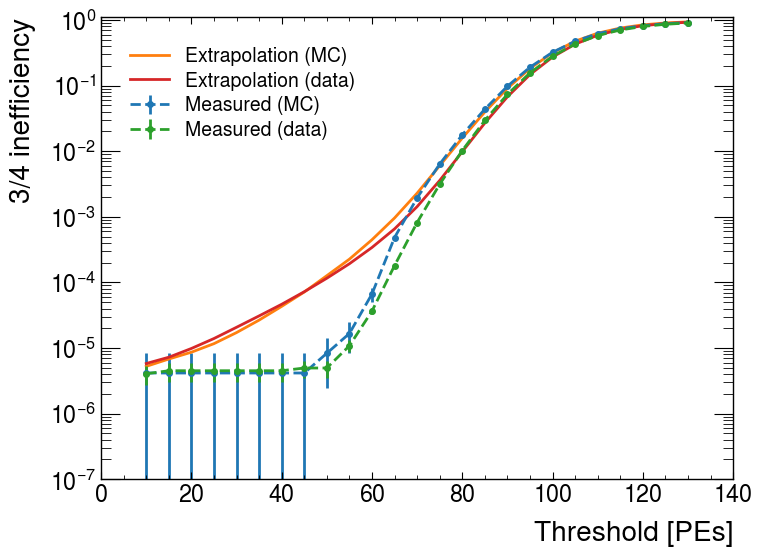

In [8]:
fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_MC_v15, yerr=error_3of4_MC_v15, fmt='.--', label='Measured (MC)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_MC_v15, '-', label='Extrapolation (MC)')
ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_3of4_data, yerr=error_3of4_data, fmt='.--', label='Measured (data)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_extrapolated_data, '-', label='Extrapolation (data)')

plt.legend(loc='upper left')

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('3/4 inefficiency')

plt.show()

In [20]:
hMCv15 = GetLightYield(ar_skim_list_MC_v15)

In [21]:
hMCv15_norm = hMCv15/hMCv15.sum()
hData_norm = hData/hData.sum()

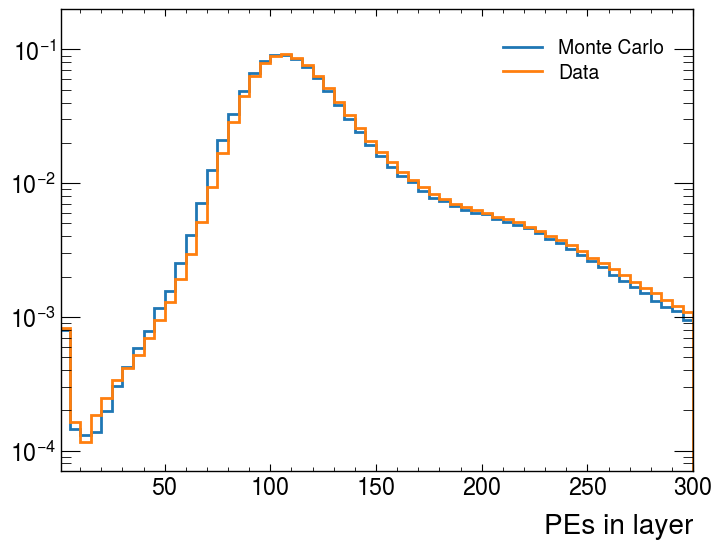

In [34]:
fig, ax = plt.subplots()
hMCv15_norm.plot1d(label='Monte Carlo', linewidth=2.0)
hData_norm.plot1d(label='Data', linewidth=2.0)
ax.legend()
ax.set_xlabel('PEs in layer')
ax.set_yscale('log')
ax.set_xlim(1,300)
ax.set_ylim(7e-5, 0.2)
plt.show()

In [12]:
ar_skim_list_data_nocleanup = SelectionCuts(DATASET_data, False, False, False)
ineff_data_nocleanup = GetEfficiencySingle(ar_skim_list_data_nocleanup)

ineff_layer1_data_single_nocleanup = ineff_data_nocleanup[0]
ineff_layer1_data_single_nocleanup = ineff_data_nocleanup[1]

ineff_1of2_extrapolated_data_nocleanup = ineff_data_nocleanup[2]
ineff_1of2_data_nocleanup = ineff_data_nocleanup[3]
error_1of2_data_nocleanup = ineff_data_nocleanup[4]

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-rec/rec/mu2e/CRV_wideband_cosmics/CRVWB-000-008-000/root/fc/22/rec.mu2e.CRV_wideband_cosmics.CRVWB-000-008-000.001720_000.root:run
497 files loaded out of 75
Total events: 9917974
Events after cuts: 4424997


In [14]:
ineff_layer1_data_single_nocleanup = ineff_data_nocleanup[0]
ineff_layer2_data_single_nocleanup = ineff_data_nocleanup[1]

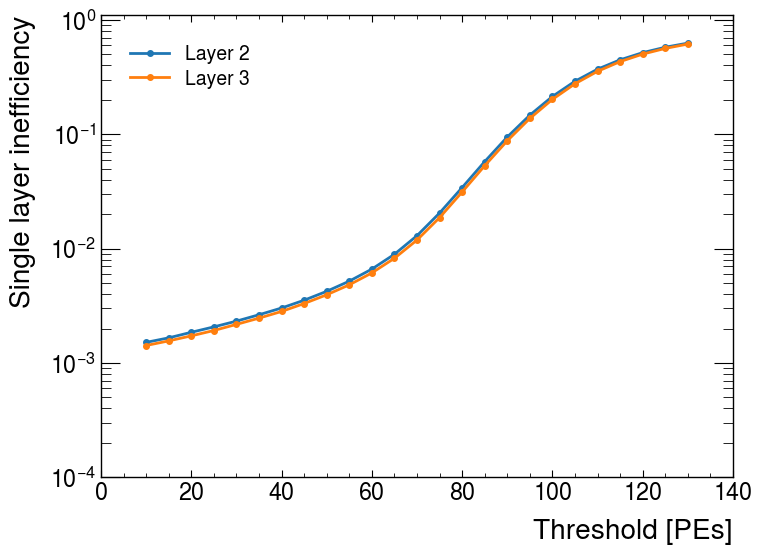

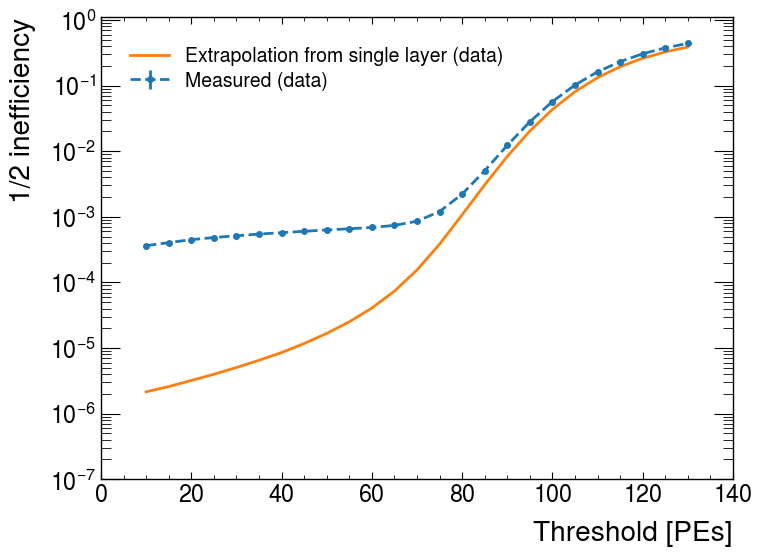

In [15]:
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_data_single_nocleanup, '.-', label='Layer 2')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_data_single_nocleanup, '.-', label='Layer 3')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

plt.show()


fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_1of2_data_nocleanup, yerr=error_1of2_data_nocleanup, fmt='.--', label='Measured (data)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_1of2_extrapolated_data_nocleanup, '-', label='Extrapolation from single layer (data)')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('1/2 inefficiency')

plt.show()

In [32]:
ar_skim_list_MC_v15_nocleanup = SelectionCuts(DATASET_MC_v15, isMC=True, isNew=True, cleanup=False)
ineff = GetEfficiencySingle(ar_skim_list_MC_v15_nocleanup)

ineff_layer1_MC_nocleanup = ineff[0]
ineff_layer2_MC_nocleanup = ineff[1]

ineff_1of2_extrapolated_MC_nocleanup = ineff[2]
ineff_1of2_MC_nocleanup = ineff[3]
error_1of2_MC_nocleanup = ineff[4]

Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v15/MDC2020ag/root/ca/78/nts.mu2e.WidebandCRV_v15.MDC2020ag.103001_00000000.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v15/MDC2020ag/root/3e/9f/nts.mu2e.WidebandCRV_v15.MDC2020ag.103001_00000160.root:CrvWidebandTest/run
Processing file: root://fndcadoor.fnal.gov:1094/mu2e/tape/phy-nts/nts/mu2e/WidebandCRV_v15/MDC2020ag/root/52/d3/nts.mu2e.WidebandCRV_v15.MDC2020ag.103001_00000321.root:CrvWidebandTest/run
504 files loaded out of 252
Total events: 14675725
Events after cuts: 454044


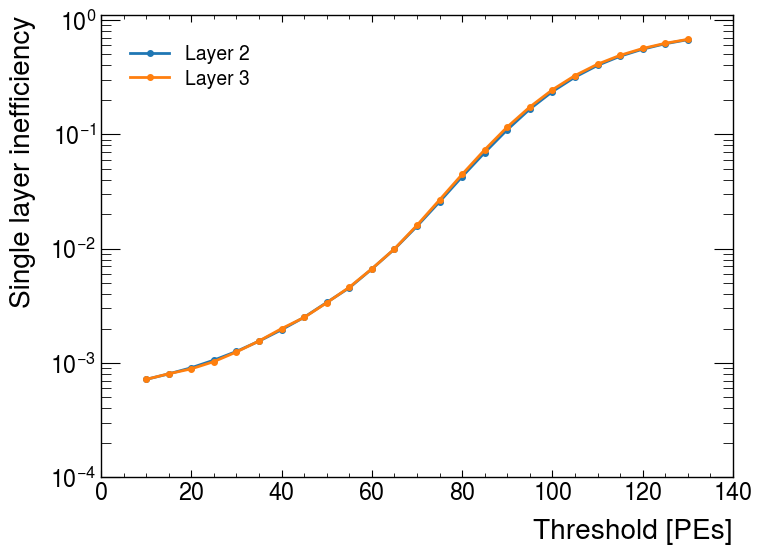

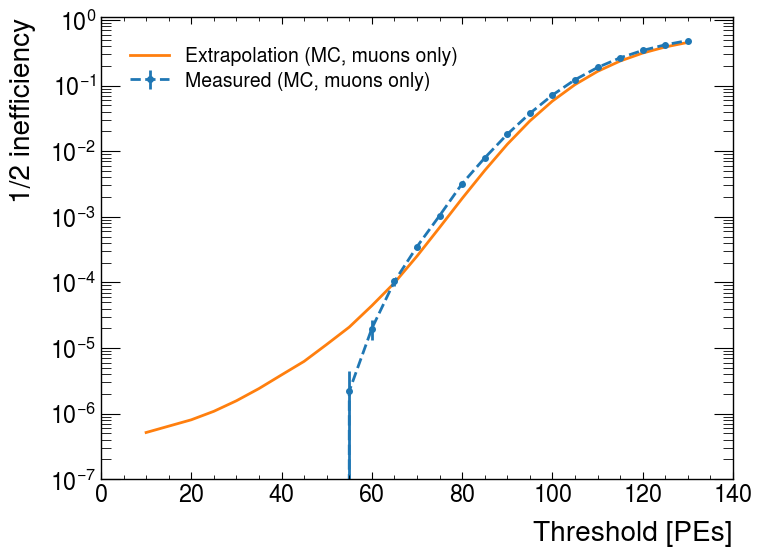

In [34]:
fig, ax = plt.subplots()

ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer1_MC_nocleanup, '.-', label='Layer 2')
ax.plot(np.linspace(10,130,25,endpoint=True), ineff_layer2_MC_nocleanup, '.-', label='Layer 3')

plt.legend()
ax.set_ylim(0.0001, 1.1)
ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('Single layer inefficiency')

plt.show()


fig, ax = plt.subplots()

ax.errorbar(np.linspace(10, 130, 25, endpoint=True), ineff_1of2_MC_nocleanup, yerr=error_1of2_MC_nocleanup, fmt='.--', label='Measured (MC, muons only)')
ax.plot(np.linspace(10, 130, 25, endpoint=True), ineff_1of2_extrapolated_MC_nocleanup, '-', label='Extrapolation (MC, muons only)')

plt.legend()

ax.set_ylim(0.0000001, 1.1)

ax.set_yscale('log')

ax.set_xlabel('Threshold [PEs]')
ax.set_ylabel('1/2 inefficiency')

plt.show()

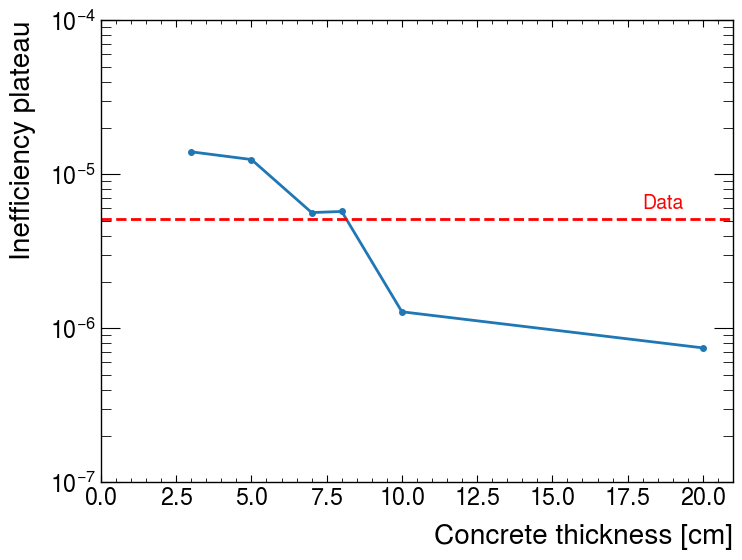

In [10]:
concrete_thickness = [20, 10, 8, 7, 5, 3]
ineff_plateau = [7.45510350e-07, 1.27906679e-06, 5.73161156e-06, 5.63895642e-06, 1.24633740e-05, 1.39821342e-05]

fig, ax = plt.subplots()

ax.plot(concrete_thickness, ineff_plateau, '.-')
ax.hlines(5.08911587e-06, 0, 21, colors='r', linestyles='dashed')

ax.text(18, 6e-6, 'Data', color='r')

ax.set_xlim((0, 21))
ax.set_yscale('log')
ax.set_xlabel('Concrete thickness [cm]')
ax.set_ylabel('Inefficiency plateau')

plt.show()